In [ ]:
%%capture
!pip install pytorch-lightning==1.4.4

In [ ]:
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

import torch
from torch import nn
import pytorch_lightning as pl
from torch.nn import functional as F

import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:

!unzip '/content/drive/MyDrive/birds_segmentation/public_tests.zip' -d '/content/drive/MyDrive/birds_segmentation/tests/'

In [ ]:
import torchvision
import torchvision.models as models
import os
import pandas as pd
from torchvision.io import read_image
from tqdm import tqdm

import numpy as np
from PIL import Image

import torch
from torchvision import transforms as T
from glob import glob
from os.path import join

In [ ]:
work_dir = '/content/drive/MyDrive/birds_segmentation/tests/00_test_val_input/train/'
test_dir_im = '/content/drive/MyDrive/birds_segmentation/tests/00_test_val_input/test/images/'
test_dir_gt = '/content/drive/MyDrive/birds_segmentation/tests/00_test_val_gt/'

In [ ]:
im_filenames = glob(join(work_dir, 'images/**/*.jpg'))
gt_filenames = glob(join(work_dir, 'gt/**/*.png'))
im_filenames_test = glob(join(test_dir_im, '**/*.jpg'))
gt_filenames_test = glob(join(test_dir_gt, '**/*.png'))

In [ ]:
mask_filenames = []

for el in im_filenames:
  splitted = el.split('/')
  gt_path = work_dir+'gt/'+splitted[-2]+'/'+splitted[-1][:-4]+'.png'
  mask_filenames.append(gt_path)

In [ ]:
mask_filenames_test = []

for el in im_filenames:
  splitted = el.split('/')
  gt_path = work_dir+'gt/'+splitted[-2]+'/'+splitted[-1][:-4]+'.png'
  mask_filenames_test.append(gt_path)

In [ ]:
mask_filenames[4], im_filenames[4]

('/content/drive/MyDrive/birds_segmentation/tests/00_test_val_input/train/gt/113.Baird_Sparrow/Baird_Sparrow_0049_787324.png',
 '/content/drive/MyDrive/birds_segmentation/tests/00_test_val_input/train/images/113.Baird_Sparrow/Baird_Sparrow_0049_787324.jpg')

In [ ]:
len(mask_filenames)

8382

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, img_path, mask_path, transform=None, target_transform=None):
    self.mask_path = mask_path
    self.img_path = img_path
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.img_path)

  def __getitem__(self, idx):
    image = Image.open(self.img_path[idx])
    mask = Image.open(self.mask_path[idx])
    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      mask = self.target_transform(mask)
    return [image, mask]


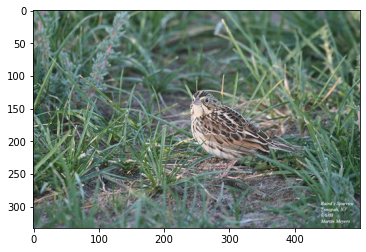

In [ ]:
im = Image.open(im_filenames[1])
plt.imshow(im)

In [ ]:
im.size

(500, 333)

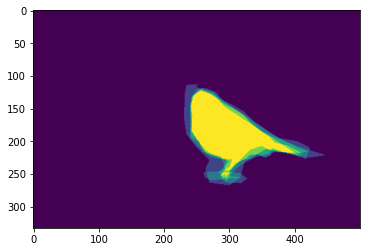

In [ ]:
mask = Image.open(mask_filenames[1])
plt.imshow(mask)

Model


In [ ]:
def convrelu(in_channels, out_channels, kernel, padding):
  return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
  )


class ResNetUNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        self.base_model = torchvision.models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

In [ ]:
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) +\
                                                 target.sum(dim=2).sum(dim=2) + smooth)))

    return loss.mean()

# Data Transform

In [ ]:
def ToRGB(arr):
    if arr.shape[0] == 1:
        return torch.cat((arr, arr, arr), dim=0)
    else:
        return arr
    
def MyPad(img):
    height, width = img.size[0], img.size[1]
    if height > width:
        tf = T.Pad(padding=(0, height - width))
    else:
        tf = T.Pad(padding=(width-height, 0))
    return tf(img)

def check_mask(mask):
    if mask.shape[0] != 1:
      return mask[:1,]
    else:
      return mask

In [ ]:
prepr = T.Compose([
  T.Lambda(MyPad),   
  T.Resize((222, 222), interpolation=T.InterpolationMode.BICUBIC),
  T.CenterCrop(160),
  T.ToTensor(),
  T.Lambda(ToRGB)
  #T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

prepr_ann = T.Compose([
  T.Lambda(MyPad),
  T.Resize((222, 222), interpolation=T.InterpolationMode.BICUBIC),
  T.CenterCrop(160),    
  T.ToTensor(),
  T.Lambda(check_mask)
])

#Lightning


In [ ]:
class MyModel(pl.LightningModule):
    # REQUIRED
    def __init__(self, num_classes):
        super().__init__()
        """ Define computations here. """
        
        self.model = ResNetUNet(num_classes)
        
        # freeze backbone layers
        for l in self.model.base_layers:
            for param in l.parameters():
                param.requires_grad = False
        
        
        self.bce_weight = 0.9
    
    # REQUIRED
    def forward(self, x):
        """ Use for inference only (separate from training_step). """
        return self.model(x)
    
    
    # REQUIRED
    def training_step(self, batch, batch_idx):
        """the full training loop"""
        img, mask = batch

        mask_logit = self(img)        
        bce = F.binary_cross_entropy_with_logits(mask_logit, mask)
        
        pred = torch.sigmoid(mask_logit)
        dice = dice_loss(pred, mask)

        loss = bce * self.bce_weight + dice * (1 - self.bce_weight) * mask.size(0)

        return {'loss': loss}


    def train_dataloader(self):
      train_dataset = CustomDataset(im_filenames[:7000], mask_filenames[:7000], prepr, prepr_ann)

      train_loader = DataLoader(train_dataset, batch_size=20, num_workers=4, shuffle = True)

      return train_loader


    def val_dataloader(self):
      val_dataset = CustomDataset(im_filenames[7000:8000], mask_filenames[7000:8000], prepr, prepr_ann)

      val_loader = DataLoader(val_dataset, batch_size=20, num_workers=4)

      return val_loader

    
    # REQUIRED
    def configure_optimizers(self):
        """ Define optimizers and LR schedulers. """
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4, weight_decay=5e-4)
        # optimizer = torch.optim.SGD(self.parameters(), lr=1e-3, momentum=0.9)
        
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                                  mode='min', 
                                                                  factor=0.1, 
                                                                  patience=1, 
                                                                  verbose=True)
        lr_dict = {
            "scheduler": lr_scheduler,
            "interval": "epoch",
            "frequency": 1,
            "monitor": "val_loss"
        } 
        
        return [optimizer], [lr_dict]
    
    # OPTIONAL
    def validation_step(self, batch, batch_idx):
        """the full validation loop"""
        img, mask = batch

        mask_logit = self(img)        
        bce = F.binary_cross_entropy_with_logits(mask_logit, mask)
        
        pred = torch.sigmoid(mask_logit)
        dice = dice_loss(pred, mask)
        
        loss = bce * self.bce_weight + dice * (1 - self.bce_weight) * mask.size(0)

        return {'val_loss': loss, 'logs':{'dice':dice, 'bce': bce}}

    # OPTIONAL
    def training_epoch_end(self, outputs):
        """log and display average train loss and accuracy across epoch"""
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        
        print(f"| Train_loss: {avg_loss:.3f}" )
        self.log('train_loss', avg_loss, prog_bar=True, on_epoch=True, on_step=False)
     
    # OPTIONAL
    def validation_epoch_end(self, outputs):
        """log and display average val loss and accuracy"""
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        
        avg_dice = torch.stack([x['logs']['dice'] for x in outputs]).mean()
        avg_bce = torch.stack([x['logs']['bce'] for x in outputs]).mean()
        
        print(f"[Epoch {self.trainer.current_epoch:3}] Val_loss: {avg_loss:.3f}, Val_dice: {avg_dice:.3f}, Val_bce: {avg_bce:.3f}", end= " ")
        self.log('val_loss', avg_loss, prog_bar=True, on_epoch=True, on_step=False)


In [ ]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

## Save the model periodically by monitoring a quantity.
MyModelCheckpoint = ModelCheckpoint(dirpath='runs/pl_segmentation',
                                    filename='{epoch}-{val_loss:.3f}',
                                    monitor='val_loss', 
                                    mode='min', 
                                    save_top_k=1)

## Monitor a metric and stop training when it stops improving.
MyEarlyStopping = EarlyStopping(monitor = "val_loss",
                                mode = "min",
                                patience = 2,
                                verbose = True)

In [ ]:
! pip install --quiet "torch>=1.6, <1.9" "pytorch-lightning>=1.3" "torchvision" "torchmetrics>=0.3"

In [ ]:
# ! pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl

In [ ]:
trainer = pl.Trainer(
    max_epochs=18,
    gpus=1
    #callbacks=[MyEarlyStopping, MyModelCheckpoint]
)


model = MyModel(num_classes = 1 )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | ResNetUNet | 18.3 M
-------------------------------------
6.6 M     Trainable params
11.7 M    Non-trainable params
18.3 M    Total params
73.251    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

[Epoch   0] Val_loss: 2.192, Val_dice: 0.787, Val_bce: 0.687 

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[Epoch   0] Val_loss: 0.608, Val_dice: 0.225, Val_bce: 0.176 | Train_loss: 0.915


Validating: 0it [00:00, ?it/s]

[Epoch   1] Val_loss: 0.528, Val_dice: 0.192, Val_bce: 0.159 | Train_loss: 0.552


Validating: 0it [00:00, ?it/s]

[Epoch   2] Val_loss: 0.488, Val_dice: 0.178, Val_bce: 0.148 | Train_loss: 0.481


Validating: 0it [00:00, ?it/s]

[Epoch   3] Val_loss: 0.486, Val_dice: 0.174, Val_bce: 0.153 | Train_loss: 0.438


Validating: 0it [00:00, ?it/s]

[Epoch   4] Val_loss: 0.488, Val_dice: 0.172, Val_bce: 0.161 | Train_loss: 0.413


Validating: 0it [00:00, ?it/s]

[Epoch   5] Val_loss: 0.452, Val_dice: 0.160, Val_bce: 0.147 | Train_loss: 0.391


Validating: 0it [00:00, ?it/s]

[Epoch   6] Val_loss: 0.441, Val_dice: 0.159, Val_bce: 0.136 | Train_loss: 0.377


Validating: 0it [00:00, ?it/s]

[Epoch   7] Val_loss: 0.429, Val_dice: 0.154, Val_bce: 0.135 | Train_loss: 0.365


Validating: 0it [00:00, ?it/s]

[Epoch   8] Val_loss: 0.438, Val_dice: 0.157, Val_bce: 0.138 | Train_loss: 0.355


Validating: 0it [00:00, ?it/s]

[Epoch   9] Val_loss: 0.430, Val_dice: 0.155, Val_bce: 0.133 | Train_loss: 0.345
Epoch    10: reducing learning rate of group 0 to 1.0000e-05.


Validating: 0it [00:00, ?it/s]

[Epoch  10] Val_loss: 0.417, Val_dice: 0.148, Val_bce: 0.134 | Train_loss: 0.325


Validating: 0it [00:00, ?it/s]

[Epoch  11] Val_loss: 0.418, Val_dice: 0.148, Val_bce: 0.135 | Train_loss: 0.320


Validating: 0it [00:00, ?it/s]

[Epoch  12] Val_loss: 0.421, Val_dice: 0.149, Val_bce: 0.137 | Train_loss: 0.317
Epoch    13: reducing learning rate of group 0 to 1.0000e-06.


Validating: 0it [00:00, ?it/s]

[Epoch  13] Val_loss: 0.419, Val_dice: 0.148, Val_bce: 0.136 | Train_loss: 0.314


Validating: 0it [00:00, ?it/s]

[Epoch  14] Val_loss: 0.419, Val_dice: 0.148, Val_bce: 0.137 | Train_loss: 0.314
Epoch    15: reducing learning rate of group 0 to 1.0000e-07.


Validating: 0it [00:00, ?it/s]

[Epoch  15] Val_loss: 0.421, Val_dice: 0.148, Val_bce: 0.138 | Train_loss: 0.313


Validating: 0it [00:00, ?it/s]

[Epoch  16] Val_loss: 0.419, Val_dice: 0.148, Val_bce: 0.137 | Train_loss: 0.313
Epoch    17: reducing learning rate of group 0 to 1.0000e-08.


Validating: 0it [00:00, ?it/s]

[Epoch  17] Val_loss: 0.418, Val_dice: 0.147, Val_bce: 0.136 | Train_loss: 0.313


In [ ]:
trainer = pl.Trainer(
    max_epochs=5,
    gpus=1
    #callbacks=[MyEarlyStopping, MyModelCheckpoint]
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | ResNetUNet | 18.3 M
-------------------------------------
6.6 M     Trainable params
11.7 M    Non-trainable params
18.3 M    Total params
73.251    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

[Epoch   0] Val_loss: 0.891, Val_dice: 0.342, Val_bce: 0.230 

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[Epoch   0] Val_loss: 0.591, Val_dice: 0.215, Val_bce: 0.178 | Train_loss: 0.692


Validating: 0it [00:00, ?it/s]

[Epoch   1] Val_loss: 0.506, Val_dice: 0.186, Val_bce: 0.149 | Train_loss: 0.533


Validating: 0it [00:00, ?it/s]

[Epoch   2] Val_loss: 0.475, Val_dice: 0.174, Val_bce: 0.142 | Train_loss: 0.471


Validating: 0it [00:00, ?it/s]

[Epoch   3] Val_loss: 0.455, Val_dice: 0.167, Val_bce: 0.136 | Train_loss: 0.430


Validating: 0it [00:00, ?it/s]

[Epoch   4] Val_loss: 0.444, Val_dice: 0.160, Val_bce: 0.138 | Train_loss: 0.405


In [ ]:
torch.save(model_base, '/content/drive/MyDrive/birds_segmentation/segmentation_model.pth')

In [ ]:
prepr_back = T.Compose([   
  T.Resize((200, 200), interpolation=T.InterpolationMode.BICUBIC),
  T.CenterCrop(160),
  T.ToTensor(),
  T.Lambda(ToRGB)
  #T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

prepr_ann_back = T.Compose([
  T.Resize((200, 200), interpolation=T.InterpolationMode.BICUBIC),
  T.CenterCrop(160),    
  T.ToTensor(),
  T.Lambda(check_mask)
])

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
def predict(model, img_path):
  model.eval()
  with torch.no_grad():
    img = Image.open(img_path)
    size = img.size

    test_dataset = CustomDataset([img_path], [img_path], prepr_back, prepr_ann_back)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)
    inputs, labels = next(iter(test_loader))
    with torch.no_grad():
      pred = model(inputs)
    pred = torch.sigmoid(pred)
    pred = pred.data
    
    pred = pred[0]

    segm = T.Resize([size[1], size[0]])(pred)

    return segm

In [ ]:
res = predict(model_base, link)

In [ ]:
res.shape

torch.Size([1, 375, 500])

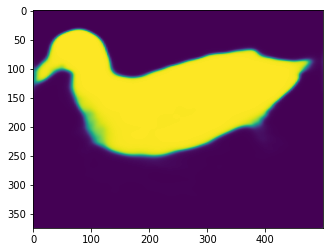

In [ ]:
plt.imshow(np.array(res).reshape([res.shape[1],res.shape[2]]))

In [ ]:
link_m = '/content/drive/MyDrive/birds_segmentation/tests/00_test_val_input/test/images/001.Black_footed_Albatross/Black_Footed_Albatross_0033_796086.jpg'

In [ ]:
link = '/content/drive/MyDrive/birds_segmentation/tests/00_test_val_input/test/images/001.Black_footed_Albatross/Black_Footed_Albatross_0033_796086.jpg'

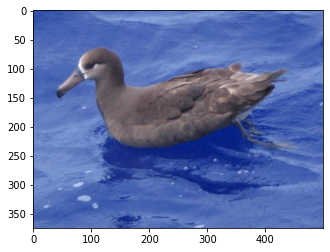

In [ ]:
plt.imshow(Image.open(link))

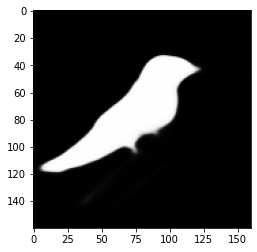

In [ ]:
import math

# Set model to the evaluation mode
model.eval()

# Create a new simulation dataset for testing
test_dataset = CustomDataset(im_filenames[7000:7010], mask_filenames[7000:7010], prepr, prepr_ann)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, num_workers=0)

# Get the first batch
inputs, labels = next(iter(test_loader))
inputs = inputs
labels = labels

# Predict
with torch.no_grad():
    pred = model(inputs)

# The loss functions include the sigmoid function.
pred = torch.sigmoid(pred)
pred = pred.data

# Change channel-order and make 3 channels for matplot
inputs.cpu()# = [reverse_transform(x) for x in inputs.cpu()]

# Map each channel (i.e. class) to each color
#target_masks_rgb = labels.cpu().numpy()
#pred_rgb =  pred
plt.imshow(torch.cat((pred[2], pred[2], pred[2])).permute(1,2,0))
#plot
#plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

In [ ]:
pred.shape

torch.Size([3, 1, 160, 160])

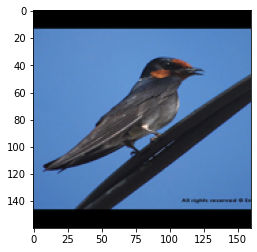

In [ ]:
plt.imshow(inputs.cpu()[2].permute(1,2,0))

In [ ]:
model_base = model.model

In [ ]:
torch.save(model2, 'model2.pth')

In [ ]:
torch.save(model_base.state_dict(), '/content/drive/MyDrive/birds_segmentation/segmentation_model.pth') 

In [ ]:
final_model = MyModel(num_classes=1)

In [ ]:
path = "/content/drive/MyDrive/CV/birds_segmentation/model.pth"

In [ ]:
final_model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
torch.save(final_model, '/content/drive/MyDrive/CV/birds_segmentation/segmentation_model.pth')